In [55]:
import pandas as pd
from pandasql import sqldf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import ConnectionPatch

plt.style.use('fivethirtyeight')
%matplotlib inline

In [22]:
data_dir = 'kaggle-survey-2018/'

In [23]:
multiple_choice = pd.read_csv(data_dir + 'multipleChoiceResponses.csv', low_memory=False)

In [24]:
def convert_salary(salary):

    if salary == '500,000+':
        return 500000
    else:
        try:
            a, b = salary.replace(',','').split('-')
            avg = (int(a)*1000+int(b))/2
            return avg
        except:
            return None

In [25]:
def convert_xp(xp, return_type):
    if xp == '30 +':
        xp = 30
    elif xp == '40+ years':
        xp = 40
    elif xp == '< 1 year':
        xp = 0.5
    else:
        try:
            a, b = xp.replace(' years', '').split('-')
            xp = (int(a)+int(b))/2
        except:
            return None
        
    if return_type == 'years':
        return xp
    elif return_type == 'seniority level':
        if xp < 3:
            return 0
        elif xp < 6:
            return 1
        else:
            return 2
    else:
        return None   

In [26]:
def convert_age(age):
    if age == '80+':
        return 80
    else:
        try:
            a, b = age.split('-')
            return (int(a)+int(b))/2
        except:
            return None

In [104]:
def convert_ind_projects(response):

    if response == 'Independent projects are much less important than academic achievements':
        return 0
    elif response == 'Independent projects are slightly less important than academic achievements':
        return 1
    elif response == 'Independent projects are equally important as academic achievements':
        return 2
    elif response == 'Independent projects are slightly more important than academic achievements':
        return 3
    elif response == 'Independent projects are much more important than academic achievements':
        return 4
    else:
        return None

In [131]:
def importance_scale(response):

    if response == 'Not at all important':
        return 0
    elif response == 'Slightly important':
        return 1
    elif response == 'Very important':
        return 2
    else:
        return None

In [132]:
df = pd.DataFrame()
df['gender'] = multiple_choice.Q1[1:]
df['current_role_xp'] = multiple_choice.Q8[1:].apply(convert_xp, args = ('years',))
df['coding_xp'] = multiple_choice.Q24[1:].apply(convert_xp, args = ('years',))
df['ml_xp'] = multiple_choice.Q25[1:].apply(convert_xp, args = ('years',))
df['current_role_xp_level'] = multiple_choice.Q8[1:].apply(convert_xp, args = ('seniority level',))
df['coding_xp_level'] = multiple_choice.Q24[1:].apply(convert_xp, args = ('seniority level',))
df['ml_xp_level'] = multiple_choice.Q25[1:].apply(convert_xp, args = ('seniority level',))
df['income'] = multiple_choice.Q9[1:].apply(convert_salary)
df['geography'] = multiple_choice.Q3[1:]
df['original_age'] = multiple_choice.Q2[1:]
df['age'] = multiple_choice.Q2[1:].apply(convert_age)
df['ind_projects_importance'] = multiple_choice.Q40[1:].apply(convert_ind_projects)
df['ml_fairness'] = multiple_choice.Q41_Part_1[1:].apply(importance_scale)
df['ml_explainability'] = multiple_choice.Q41_Part_2[1:].apply(importance_scale)
df['ml_reproducibility'] = multiple_choice.Q41_Part_3[1:].apply(importance_scale)

df = df[df.gender.isin(['Male', 'Female'])]

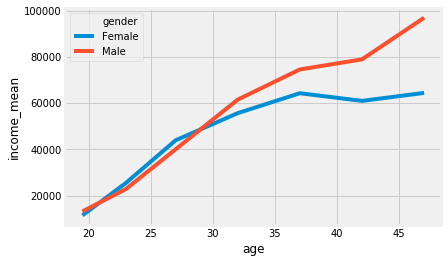

In [28]:
df_plot = sqldf("""
with bd as (
    select gender, age, avg(income) as income_mean, sum(case when income is not null then 1 else 0 end) as income_count
    from df
    group by 1, 2
)
, fl as (
    select *
    from bd
    where gender = 'Female'
    and income_count >= 50
)
, ml as (
    select *
    from bd
    where gender = 'Male'
    and income_count >= 50
)
, ages as (
    select distinct fl.age
    from fl
    join ml on fl.age = ml.age
)
select *
from fl
where age in (select * from ages)
UNION ALL
select *
from ml
where age in (select * from ages)
""")

sns.lineplot(x = 'age', y='income_mean', hue='gender', data=df_plot)
plt.show()

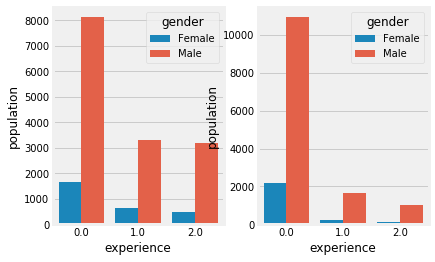

In [29]:
df_plot = sqldf("""
select gender, coding_xp_level as experience, 'coding_xp' as dimension, count(*) as population
from df
where coding_xp_level is not null
group by 1, 2
UNION ALL
select gender, ml_xp_level as experience, 'ml_xp' as dimension, count(*) as population
from df
where ml_xp_level is not null
group by 1, 2
""")

fix, axs = plt.subplots(ncols=2)
sns.barplot(x='experience', y='population', hue='gender', data=df_plot[df_plot['dimension']=='coding_xp'], ax=axs[0])
sns.barplot(x='experience', y='population', hue='gender', data=df_plot[df_plot['dimension']=='ml_xp'], ax=axs[1])
plt.show()

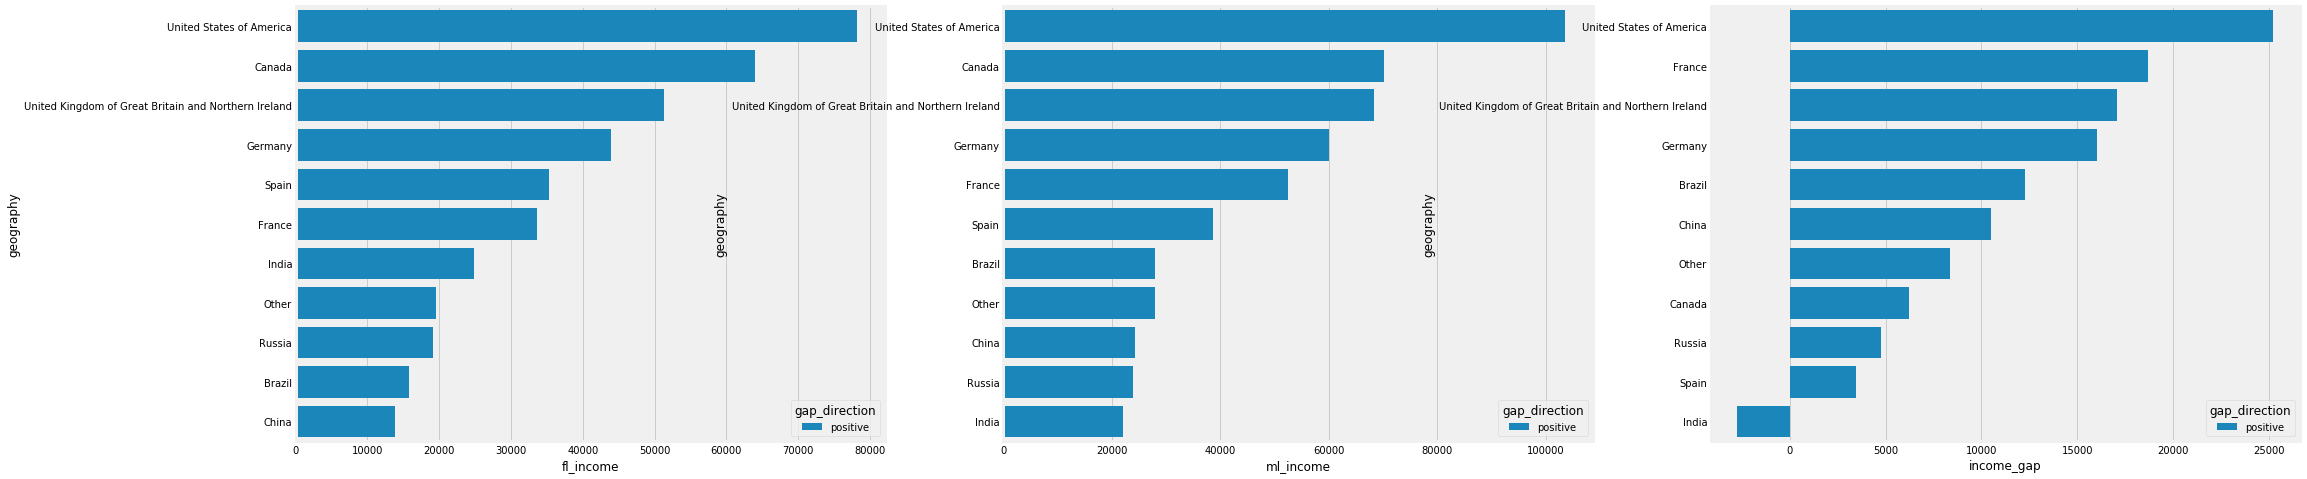

In [56]:
df_plot = sqldf("""
with bd as (
    select gender, geography, avg(income) as income_mean, sum(case when income is not null then 1 else 0 end) as income_count
    from df
    group by 1, 2
)
, fl as (
    select *
    from bd
    where gender = 'Female'
    and income_count >= 50
)
, ml as (
    select *
    from bd
    where gender = 'Male'
    and income_count >= 50
)
, geos as (
    select distinct fl.geography
    from fl
    join ml on fl.geography = ml.geography
)
select fl.geography, fl.income_mean as fl_income, ml.income_mean as ml_income, (ml.income_mean-fl.income_mean) as income_gap, case when (ml.income_mean-fl.income_mean) > 0 then 'positive' else 'positive' end as gap_direction
from fl
join ml on fl.geography = ml.geography
where fl.geography in (select * from geos)
order by (ml.income_mean-fl.income_mean) desc
"""
)


fig, axs = plt.subplots(ncols=3, figsize=(32, 8))
sns.barplot(x='fl_income', y='geography', hue='gap_direction', data=df_plot.sort_values(by='fl_income', ascending = False), ax=axs[0])
sns.barplot(x='ml_income', y='geography', hue='gap_direction', data=df_plot.sort_values(by='ml_income', ascending = False), ax=axs[1])
sns.barplot(x='income_gap', y='geography', hue='gap_direction', data=df_plot.sort_values(by='income_gap', ascending = False), ax=axs[2])
plt.show()

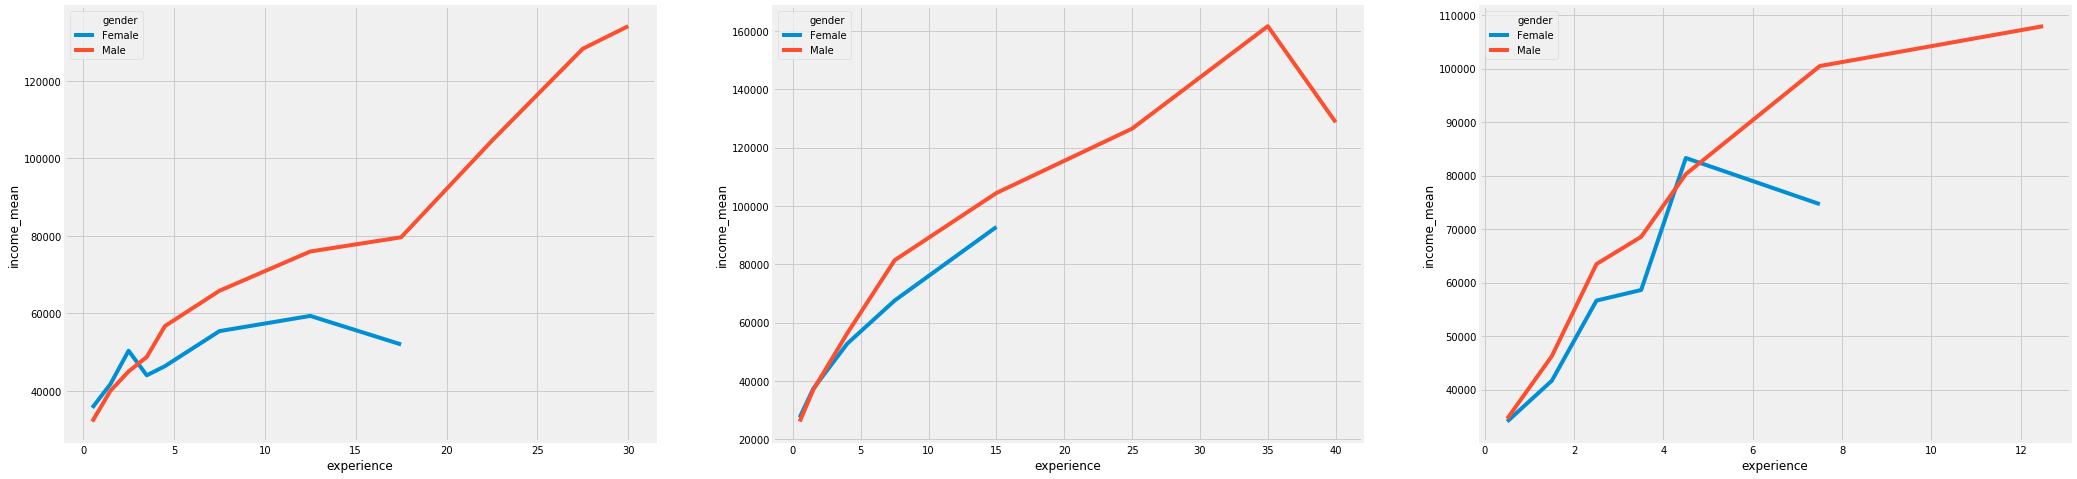

In [71]:
df_plot = sqldf("""
select gender, current_role_xp as experience, 'current_role_xp' as dimension, avg(income) as income_mean,  count(*) as population
from df
where current_role_xp is not null
group by 1, 2, 3
UNION ALL
select gender, coding_xp as experience, 'coding_xp' as dimension, avg(income) as income_mean,  count(*) as population
from df
where coding_xp is not null
group by 1, 2, 3
UNION ALL
select gender, ml_xp as experience, 'ml_xp' as dimension, avg(income) as income_mean,  count(*) as population
from df
where ml_xp is not null
group by 1, 2, 3
""")

df_plot = df_plot[df_plot['population']>=50]

fig, axs = plt.subplots(ncols=3, figsize=(32, 8))
sns.lineplot(x = 'experience', y='income_mean', hue='gender', data=df_plot[df_plot['dimension']=='current_role_xp'], ax=axs[0])
sns.lineplot(x = 'experience', y='income_mean', hue='gender', data=df_plot[df_plot['dimension']=='coding_xp'], ax=axs[1])
sns.lineplot(x = 'experience', y='income_mean', hue='gender', data=df_plot[df_plot['dimension']=='ml_xp'], ax=axs[2])
plt.show()


In [107]:
df.head()

,gender,current_role_xp,coding_xp,ml_xp,current_role_xp_level,coding_xp_level,ml_xp_level,income,geography,original_age,age,ind_projects_importance
1,Female,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United States of America,45-49,47.0,2.0
2,Male,7.5,NaN,NaN,2.0,NaN,NaN,15000.0,Indonesia,30-34,32.0,2.0
3,Female,0.5,7.5,0.5,0.0,2.0,0.0,5000.0,United States of America,30-34,32.0,2.0
4,Male,NaN,7.5,4.5,NaN,2.0,1.0,NaN,United States of America,35-39,37.0,4.0
5,Male,0.5,7.5,2.5,0.0,2.0,0.0,5000.0,India,22-24,23.0,3.0


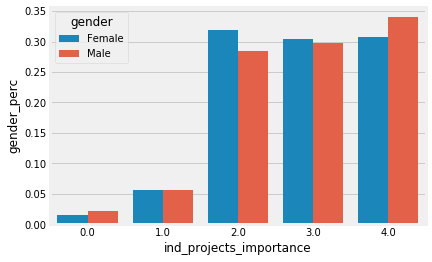

In [122]:
df_plot = sqldf("""
with total_counts as (
    select gender, count(*) as gender_count
    from df
    where ind_projects_importance is not null
    group by 1
)
select df.ind_projects_importance, df.gender, tc.gender_count, count(*), count(*)*1.0/tc.gender_count as gender_perc
from df
join total_counts tc on df.gender = tc.gender
where df.gender = 'Female' and df.ind_projects_importance is not null
group by 1, 2, 3
UNION ALL
select df.ind_projects_importance, df.gender, tc.gender_count, count(*), count(*)*1.0/tc.gender_count as gender_perc
from df
join total_counts tc on df.gender = tc.gender
where df.gender = 'Male' and df.ind_projects_importance is not null
group by 1, 2, 3
""")

sns.barplot(x='ind_projects_importance', y='gender_perc', hue='gender', data=df_plot.sort_values(by='ind_projects_importance'))
plt.show()

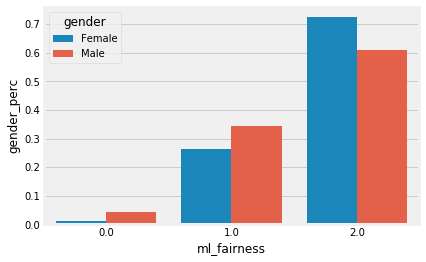

In [135]:
df_plot = sqldf("""
with total_counts as (
    select gender, count(*) as gender_count
    from df
    where ml_fairness is not null
    group by 1
)
select df.ml_fairness, df.gender, tc.gender_count, count(*), count(*)*1.0/tc.gender_count as gender_perc
from df
join total_counts tc on df.gender = tc.gender
where df.gender = 'Female' and df.ml_fairness is not null
group by 1, 2, 3
UNION ALL
select df.ml_fairness, df.gender, tc.gender_count, count(*), count(*)*1.0/tc.gender_count as gender_perc
from df
join total_counts tc on df.gender = tc.gender
where df.gender = 'Male' and df.ml_fairness is not null
group by 1, 2, 3
""")

sns.barplot(x='ml_fairness', y='gender_perc', hue='gender', data=df_plot.sort_values(by='ml_fairness'))
plt.show()

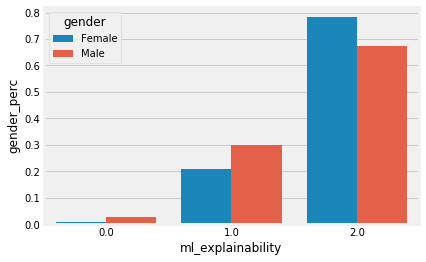

In [136]:
df_plot = sqldf("""
with total_counts as (
    select gender, count(*) as gender_count
    from df
    where ml_explainability is not null
    group by 1
)
select df.ml_explainability, df.gender, tc.gender_count, count(*), count(*)*1.0/tc.gender_count as gender_perc
from df
join total_counts tc on df.gender = tc.gender
where df.gender = 'Female' and df.ml_explainability is not null
group by 1, 2, 3
UNION ALL
select df.ml_explainability, df.gender, tc.gender_count, count(*), count(*)*1.0/tc.gender_count as gender_perc
from df
join total_counts tc on df.gender = tc.gender
where df.gender = 'Male' and df.ml_explainability is not null
group by 1, 2, 3
""")

sns.barplot(x='ml_explainability', y='gender_perc', hue='gender', data=df_plot.sort_values(by='ml_explainability'))
plt.show()

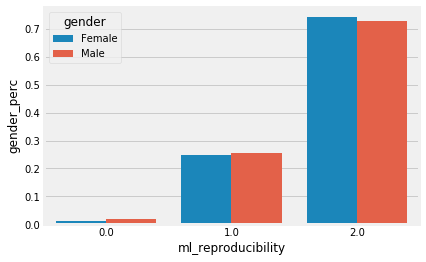

In [137]:
df_plot = sqldf("""
with total_counts as (
    select gender, count(*) as gender_count
    from df
    where ml_reproducibility is not null
    group by 1
)
select df.ml_reproducibility, df.gender, tc.gender_count, count(*), count(*)*1.0/tc.gender_count as gender_perc
from df
join total_counts tc on df.gender = tc.gender
where df.gender = 'Female' and df.ml_reproducibility is not null
group by 1, 2, 3
UNION ALL
select df.ml_reproducibility, df.gender, tc.gender_count, count(*), count(*)*1.0/tc.gender_count as gender_perc
from df
join total_counts tc on df.gender = tc.gender
where df.gender = 'Male' and df.ml_reproducibility is not null
group by 1, 2, 3
""")

sns.barplot(x='ml_reproducibility', y='gender_perc', hue='gender', data=df_plot.sort_values(by='ml_reproducibility'))
plt.show()